In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio

100% 428M/429M [00:11<00:00, 40.0MB/s]
100% 429M/429M [00:11<00:00, 38.1MB/s]


In [ ]:
!unzip /content/ravdess-emotional-speech-audio.zip -d /content/dataset

In [ ]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [ ]:
dataset_path = "/content/dataset/"

In [ ]:
import os
import pandas as pd

ravdess_directory_list = os.listdir(dataset_path)

data = []

for dir in ravdess_directory_list:
    actor_path = os.path.join(dataset_path, dir)
    actor_files = os.listdir(actor_path)

    for file in actor_files:
        parts = file.split('.')[0].split('-')

        if len(parts) >= 3:
            emotion = int(parts[2])
            file_path = os.path.join(actor_path, file)

            data.append({'Emotions': emotion, 'Path': file_path})

ravdess_df = pd.DataFrame(data)

# Mapping integer labels to actual emotions
emotion_mapping = {
    1: 'neutral',
    2: 'calm',
    3: 'happy',
    4: 'sad',
    5: 'angry',
    6: 'fear',
    7: 'disgust',
    8: 'surprise'
}

ravdess_df['Emotions'] = Ravdess_df['Emotions'].map(emotion_mapping)

ravdess_df.head()

,Emotions,Path
0,angry,/content/dataset/Actor_02/03-01-05-01-02-02-02...
1,sad,/content/dataset/Actor_02/03-01-04-01-01-02-02...
2,sad,/content/dataset/Actor_02/03-01-04-01-01-01-02...
3,calm,/content/dataset/Actor_02/03-01-02-01-02-01-02...
4,surprise,/content/dataset/Actor_02/03-01-08-02-01-01-02...


In [ ]:
# creating Dataframe using the Ravdess dataset
data_path = ravdess_df
data_path.to_csv("data_path.csv",index=False)
data_path.head()

,Emotions,Path
0,angry,/content/dataset/Actor_02/03-01-05-01-02-02-02...
1,sad,/content/dataset/Actor_02/03-01-04-01-01-02-02...
2,sad,/content/dataset/Actor_02/03-01-04-01-01-01-02...
3,calm,/content/dataset/Actor_02/03-01-02-01-02-01-02...
4,surprise,/content/dataset/Actor_02/03-01-08-02-01-01-02...


In [ ]:
import matplotlib.pyplot as plt

# Get counts of each emotion
emotion_counts = data_path['Emotions'].value_counts()

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure(figsize=(10,6))
plt.bar(emotion_counts.index, emotion_counts.values, color=colors[:len(emotion_counts)], alpha=0.7)
plt.title('', size=16)
plt.xlabel('Emotions Distribution', size=12)
plt.ylabel('Count', size=12)
plt.grid(axis='y')
plt.show()

In [ ]:
def noise(data):
    noise_amp = 0.04*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate=rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sr=sampling_rate, n_steps=pitch_factor)

path = np.array(data_path.Path)[1]
audio_sample, sample_rate = librosa.load(path)

In [ ]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(data, sr=sample_rate)
plt.title('Original Audio File')
plt.show()
Audio(path)

In [ ]:
x = noise(audio_sample)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('White Noise Audio File')
Audio(x, rate=sample_rate)

In [ ]:
x = stretch(audio_sample)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Stretched Audio File')
Audio(x, rate=sample_rate)

In [ ]:
x = shift(audio_sample)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Shifted Audio File')
Audio(x, rate=sample_rate)

In [ ]:
x = pitch(audio_sample, sample_rate)
plt.figure(figsize=(14,4))
librosa.display.waveshow(y=x, sr=sample_rate)
plt.title('Pitched Audio File')
Audio(x, rate=sample_rate)

In [ ]:
def extract_features(data, sample_rate):
    features = []

    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    features.append(chroma_stft)

    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    features.append(rms)

    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    features.append(mel)

    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    features.append(mfcc)

    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    features.append(zcr)

    return np.hstack(features)

In [ ]:
def get_features(path):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    res1 = extract_features(data, sample_rate)
    result = np.array(res1)

    noise_data = noise(data)
    res2 = extract_features(noise_data, sample_rate)
    result = np.vstack((result, res2))

    augmented_data = pitch(stretch(data), sample_rate)
    res3 = extract_features(augmented_data, sample_rate)
    result = np.vstack((result, res3))

    return result

In [ ]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        Y.append(emotion)

In [ ]:
len(X), len(Y), data_path.Path.shape

(4320, 4320, (1440,))

In [ ]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('/content/features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.664279,0.593576,0.555406,0.548036,0.542235,0.602386,0.686092,0.613681,0.573192,0.581038,...,-12.950767,2.208733,-8.964414,-5.237410,-4.900717,-9.421363,-9.965914,-3.001678,0.222218,angry
1,0.733214,0.716363,0.706174,0.678210,0.688533,0.668748,0.695429,0.634463,0.636552,0.679745,...,-4.799719,-0.632521,-2.621232,-3.988329,-2.691731,-5.349362,-6.623987,-2.801123,0.296861,angry
2,0.635457,0.642084,0.568259,0.549310,0.532585,0.502982,0.566992,0.715170,0.646096,0.550566,...,-11.089360,3.643390,-11.127197,-4.428462,-8.280272,-10.085418,-8.198171,0.599946,0.192115,angry
3,0.484732,0.403829,0.449593,0.510690,0.473447,0.472625,0.470697,0.535387,0.645654,0.623645,...,-7.787284,0.990069,-8.538687,-4.951330,-6.842031,-3.471666,-7.752641,-3.582913,0.180614,sad
4,0.620235,0.579473,0.573388,0.656299,0.653030,0.625835,0.572575,0.588700,0.657223,0.709917,...,-3.338059,-2.502190,-5.168828,-4.964290,-5.051102,-4.221855,-4.512886,-3.307372,0.253734,sad


In [ ]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [ ]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162), (3240, 8), (1080, 162), (1080, 8))

In [ ]:
x_train = np.expand_dims(x_train, axis=1)
x_test = np.expand_dims(x_test, axis=1)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 1, 162), (3240, 8), (1080, 1, 162), (1080, 8))

In [ ]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((3240, 162, 1), (3240, 8), (1080, 162, 1), (1080, 8))

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from keras.optimizers import Adam

num_features = x_train.shape[2]
num_classes = 8

model = Sequential()

model.add(LSTM(128, return_sequences=True, input_shape=(1, num_features)))
model.add(Dropout(0.2))

model.add(LSTM(64))
model.add(Dropout(0.2))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(num_classes, activation='softmax'))

adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()

In [ ]:
model = Sequential([
    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(x_train.shape[1], 1)),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),

    Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),

    Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),
    Dropout(0.2),

    Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'),
    MaxPooling1D(pool_size=5, strides=2, padding='same'),

    Flatten(),
    Dense(units=32, activation='relu'),
    Dropout(0.3),

    Dense(units=8, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

In [ ]:
# rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=0, patience=2, min_lr=0.0000001)
history=model.fit(x_train, y_train, batch_size=64, epochs=150, validation_data=(x_test, y_test))

Epoch 1/150
51/51 [==============================] - 5s 28ms/step - loss: 2.0092 - accuracy: 0.2343 - val_loss: 1.8934 - val_accuracy: 0.2537
Epoch 2/150
51/51 [==============================] - 1s 13ms/step - loss: 1.7616 - accuracy: 0.3253 - val_loss: 1.6521 - val_accuracy: 0.3694
Epoch 3/150
51/51 [==============================] - 1s 14ms/step - loss: 1.5665 - accuracy: 0.4164 - val_loss: 1.5033 - val_accuracy: 0.4463
Epoch 4/150
51/51 [==============================] - 1s 12ms/step - loss: 1.4247 - accuracy: 0.4707 - val_loss: 1.3883 - val_accuracy: 0.4787
Epoch 5/150
51/51 [==============================] - 1s 12ms/step - loss: 1.3224 - accuracy: 0.5154 - val_loss: 1.3122 - val_accuracy: 0.5176
Epoch 6/150
51/51 [==============================] - 1s 11ms/step - loss: 1.2441 - accuracy: 0.5414 - val_loss: 1.2662 - val_accuracy: 0.5296
Epoch 7/150
51/51 [==============================] - 1s 14ms/step - loss: 1.1740 - accuracy: 0.5676 - val_loss: 1.2289 - val_accuracy: 0.5491
Epoch 

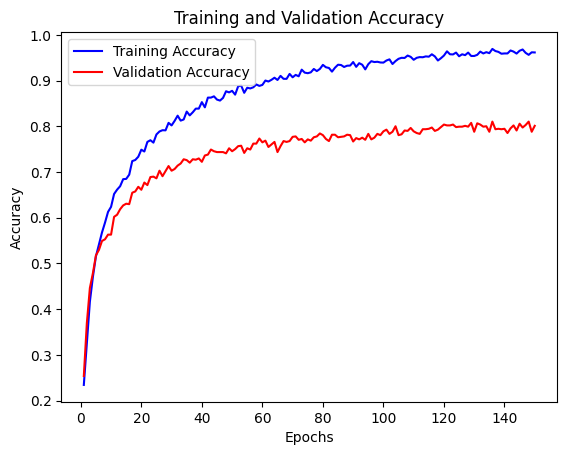

In [ ]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Plot the accuracy curve
epochs = range(1, len(train_acc) + 1)
plt.plot(epochs, train_acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

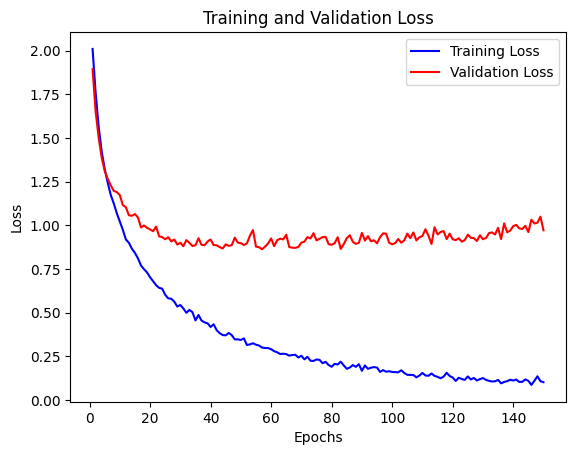

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the loss curve
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

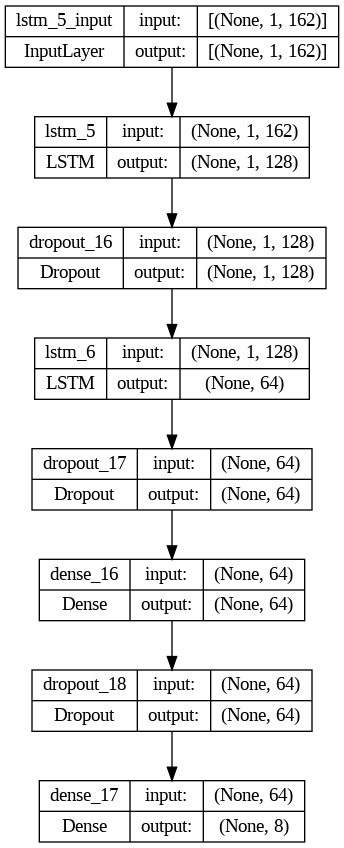

In [ ]:
import graphviz
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.optimizers import Adam

num_features = x_train.shape[1]
num_classes = 8

model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(num_features,)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(num_classes, activation='softmax'))

adam = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 256)               41728     
                                                                 
 dropout_11 (Dropout)        (None, 256)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 128)               32896     
                                                                 
 dropout_12 (Dropout)        (None, 128)               0         
                                                                 
 batch_normalization_7 (Batc  (None, 128)              512       
 hNormalization)                                      

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import time

# Specify the hyperparameter search space
hp = HyperParameters()

hp.Choice('units', values=[64, 128, 256])
hp.Choice('dropout', values=[0.2, 0.3, 0.4])

# Define a function that will build and compile a model given a set of hyperparameters
def build_model(hp):
    model = Sequential()

    model.add(LSTM(units=hp.get('units'), return_sequences=True, input_shape=(x_train.shape[1], 1)))
    model.add(Dropout(rate=hp.get('dropout')))

    model.add(LSTM(units=hp.get('units')))
    model.add(Dropout(rate=hp.get('dropout')))

    model.add(Dense(units=hp.get('units'), activation='relu'))
    model.add(Dropout(rate=hp.get('dropout')))

    model.add(Dense(units=hp.get('units'), activation='relu'))

    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.001), metrics=['accuracy'])

    return model

# Perform the hyperparameter search
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # the number of different models to try
    executions_per_trial=3,  # the number of times to train each model, to average out performance fluctuations
    directory='random_search',
    project_name=str(time.time())  # name of the directory where the results will be stored
)

tuner.search_space_summary()

tuner.search(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

tuner.results_summary()


CNN + LSTM (SPECTROGRAMS)

In [ ]:
data_path

In [ ]:
path = "/content/dataset/Actor_01/03-01-03-01-02-01-01.wav"
audio_data, sample_rate = librosa.load(path)

In [ ]:
def plot_histogram(stft):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.amplitude_to_db(abs(stft), ref=np.max), y_axis='log', x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Spectrogram')
    plt.tight_layout()
    plt.show()

In [ ]:
# Compute the Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate)

# Convert to log scale (dB)
mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# Plot the Mel spectrogram
plt.figure(figsize=(10, 6))
librosa.display.specshow(mel_spec_db, sr=sample_rate, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel Spectrogram of Happy Sample', size=16)
plt.xlabel('Time (s)', size=12)
plt.ylabel('Mel Frequency', size=12)
plt.tight_layout()
plt.show()

In [ ]:
def get_spectrogram(data, sample_rate):
    spec = librosa.feature.melspectrogram(y=data, sr=sample_rate)
    return spec

In [ ]:
get_spectrogram(data).shape

(1025, 108)

In [ ]:
def save_spectrogram(feature):
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(librosa.power_to_db(feature, ref=np.max), y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')

    plt.savefig(f"/content/spectrograms/{emotion}/spectrogram_{index}.png")
    plt.close()

In [ ]:
index = 0
for path, emotion in zip(data_path.Path, data_path.Emotions):
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    noise_data = noise(audio_data)
    stretched_data = noise(audio_data)
    shifted_data = shift(audio_data)
    pitched_data = pitch(audio_data, sample_rate)

    feature = get_spectrogram(data, sample_rate)
    save_spectrogram(feature)
    index += 1

In [ ]:
from PIL import Image

img = Image.open('/content/spectrograms/angry/spectrogram_1002.png')

# Get the size of the image
width, height = img.size

print('Width: ', width)
print('Height: ', height)

Width:  1000
Height:  400


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = datagen.flow_from_directory(
    '/content/spectrograms/',
    target_size=(500, 200),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    color_mode = 'rgb'
)

validation_generator = datagen.flow_from_directory(
    '/content/spectrograms/',
    target_size=(500, 200),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    color_mode ='rgb'
)

Found 1155 images belonging to 9 classes.
Found 285 images belonging to 9 classes.


In [ ]:
print(train_generator.class_indices)

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam

img_height = 500
img_width = 200
num_classes = 9
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(img_height, img_width, 3)),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(num_classes, activation='softmax')
])

model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 498, 198, 32)      896       
                                                                 
 batch_normalization_5 (Batc  (None, 498, 198, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 249, 99, 32)      0         
 2D)                                                             
                                                                 
 conv2d_15 (Conv2D)          (None, 247, 97, 64)       18496     
                                                                 
 batch_normalization_6 (Batc  (None, 247, 97, 64)      256       
 hNormalization)                                                 
                                                      

In [ ]:
model.fit(train_generator, epochs=10, validation_data=validation_generator)

In [ ]:
for index in range(0, len(X)):
  if X[index].shape != (1025, 108):
    data = X[index]
    data = np.pad(data, pad_width=((0, 0), (0, 108 - data.shape[1])), mode='constant')
    X[index] = data
    print(X[index].shape)

In [ ]:
X = np.asarray(X)
X.shape

(1440, 1025, 108)

In [ ]:
pip install --upgrade tensorflow

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Concatenate, Activation
from tensorflow.keras.models import Model

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential(
            [tf.keras.layers.Dense(ff_dim, activation="relu"), tf.keras.layers.Dense(embed_dim),]
        )
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


def create_timnet(input_shape, num_classes, num_filters=64, num_blocks=3, kernel_size=2):
    inputs = Input(shape=input_shape)

    feature_maps = []

    for i in range(num_blocks):
        dilation_rate = 2 ** i

        # Temporal-aware block
        conv1 = Conv1D(filters=num_filters, kernel_size=kernel_size,
                       dilation_rate=dilation_rate, padding='causal')(inputs)
        conv1 = Activation('relu')(conv1)

        conv2 = Conv1D(filters=num_filters, kernel_size=kernel_size,
                       dilation_rate=dilation_rate, padding='causal')(conv1)
        conv2 = Activation('relu')(conv2)

        # Add a transformer block after the convolutions
        transformer_block = TransformerBlock(num_filters, num_heads=2, ff_dim=num_filters)
        conv2 = transformer_block(conv2)

        # Global average pooling to get a fixed size output irrespective of input size
        gap = GlobalAveragePooling1D()(conv2)

        feature_maps.append(gap)

    # Concatenate the feature maps
    concatenated = Concatenate()(feature_maps)

    # Final prediction layer
    outputs = Dense(num_classes, activation='softmax')(concatenated)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model
